In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2 # подгрузка и работа с данными
import os
import tqdm # счетчик и красивый прогресс бар

In [2]:
IMAGE_PATH = 'make_rofneft_predict/data/train/images/'
MASK_PATH = 'make_rofneft_predict/data/train/train.csv'
TEST_PATH = 'make_rofneft_predict/data/test/images/'
SAMPLE_PATH = 'make_rofneft_predict/data/sample_submission.csv'

def rle2mask(mask_rle, shape):
    # эта функция взята с конкурса и я её оставил как есть
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [3]:
class TrainDataset():
    # немного переписанный загрузчик данных опять же с конкурса
    def __init__(self, image_dir, train):
        self.image_dir = image_dir
        self.train = train
        self.image_uses = []

    def __getitem__(self, index):
        
        
        img_name = self.train.iloc[index]['ImageId']
        if img_name in self.image_uses:
            return 'hups'
        else:
            self.image_uses.append(img_name)
            path = os.path.join(self.image_dir, img_name)
            img = cv2.imread(path,0)
            img = cv2.resize(img,(384,384))

            ce_mask = [
                (i + 1) * rle2mask(rle, shape=(img.shape[0], img.shape[1])) \
                    for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
            ]
            ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)


            result = {
                'image':img, 
                'mask': ce_mask,
                'pick_name':img_name
            }
            return result
    
    def __len__(self, ):
        return len(self.train)

In [4]:

train = pd.read_csv(MASK_PATH)

train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train)

In [5]:

x_images = []
y_images = []

for i in train_dataset:
    if type(i)==str:
        pass
    else:
        x_images.append(i['image'])
        y_images.append(i['mask'])

In [6]:
# удобнее работать



In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(picture_model,mask_model,test_size=0.15)

In [8]:
#### наш рукописный бейзлайн

classes=[0,1,2,3,4,5,6,7]
dict_start={}
dict_end={}
dict_start
for ob_class in classes:
    dict_start[ob_class]=[]
    dict_end[ob_class]=[]
for y_trr in Y_train:
    first_col=y_trr[:,0]
    dict_start[0].append(0)
    for ob_class in classes:
        for i in range(1,len(first_col)):
            if first_col[i]==ob_class and first_col[i-1]!=ob_class:   
                dict_start[ob_class].append(i)
            elif first_col[i-1]==ob_class and first_col[i]!=ob_class:
                dict_end[ob_class].append(i)
                break

In [9]:
dict_total={}
for ob_class in classes:
    dict_total[ob_class]=[np.median(dict_start[ob_class]).astype(int),np.median(dict_end[ob_class]).astype(int)]


Text(0.5, 1.0, 'y_images_baseline')

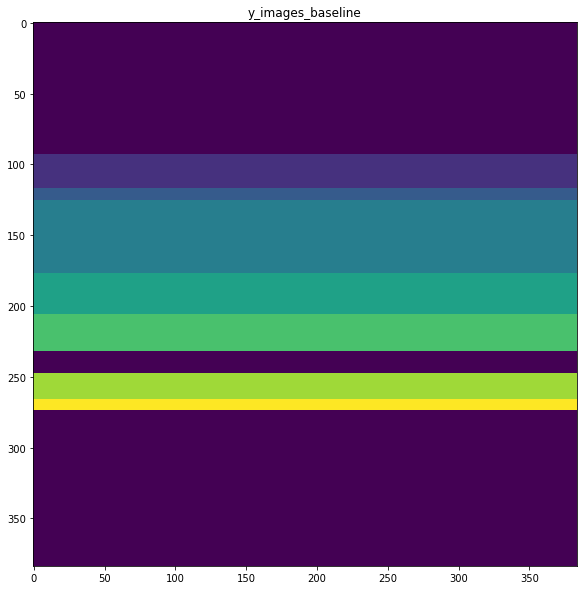

In [10]:
# Применяем наш бейзлайн, чтобы потом можно было сравнивать
# Честно украденный из решения студента :)
y_images_baseline=np.zeros(y_images[0].shape,dtype=int)
for ob_cl,bound in dict_total.items():
    y_images_baseline[bound[0]:bound[1],:]=ob_cl
plt.figure(figsize=(20,10))
plt.imshow(y_images_baseline)
plt.title("y_images_baseline")

In [11]:
# собранная моделька, просто какая-то, без намека на оптимальность
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = picture_model[0].shape

# Вход в сетку 
inputs = L.Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128
down1 = L.Conv2D(16, (3, 3), activation="relu", padding='same')(inputs)
down1 = L.Conv2D(16, (3, 3), activation="relu", padding='same')(down1)
drop1 = L.Dropout(0.2)(down1)
down1_pool = L.MaxPooling2D((2, 2))(drop1)

# 64
down2 = L.Conv2D(32, (3, 3), activation="relu", padding='same')(down1_pool)
down2 = L.Conv2D(32, (3, 3), activation="relu", padding='same')(down2)
drop2 = L.Dropout(0.2)(down2)
down2_pool = L.MaxPooling2D((2, 2))(drop2)


# 8
center = L.Conv2D(64, (3, 3), activation="relu", padding='same')(down2_pool)
center = L.Conv2D(64, (3, 3), activation="relu", padding='same')(center)
center = L.Dropout(0.2)(center)

# center

up2 = L.UpSampling2D((2, 2),interpolation='bilinear')(center)
up2 = L.concatenate([down2, up2], axis=3)  # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up2 = L.Conv2D(32, (3, 3), activation="relu", padding='same')(up2)
up2 = L.Conv2D(32, (3, 3), activation="relu", padding='same')(up2)
drop_up2 = L.Dropout(0.5)(up2)

# 64
up1 = L.UpSampling2D((2, 2),interpolation='bilinear')(drop_up2)
up1 = L.concatenate([down1, up1], axis=3) # ПРОКИНУЛИ СВЯЗЬ МЕЖДУ СТАРЫМ И НОВЫМ!!! 

up1 = L.Conv2D(16, (3, 3), activation="relu", padding='same')(up1)
up1 = L.Conv2D(16, (3, 3), activation="relu", padding='same')(up1)
drop_u1 = L.Dropout(0.2)(up1)



# 128
outputs = L.Conv2D(8, (1, 1),activation='softmax')(drop_u1)
model_unet = Model(inputs=inputs, outputs=outputs)

In [14]:
# наш вариант dice для софтмакса
######### пишем сами

Получаем бейзлайн

In [16]:
## нам надо получить вектор из бейзлайна
######### пишем сами

In [19]:
# считаем метрику на бейзлайне, нам это нужно чтобы понять - делает ли вообще что-то наша модель
dice_metric_base(y_true,y_images_baseline_vec)

<tf.Tensor: id=847, shape=(), dtype=float32, numpy=0.6305845>

In [20]:
optimizer = tf.optimizers.Adam()

# при обучении можем следить за метрикой
model_unet.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy",
     metrics = ['sparse_categorical_accuracy',dice_metric_acc_v]
)

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# ну и 2 наших самых важных callback
# они тоже опираются на нашу метрику
save_model = ModelCheckpoint('unet_small.h5',monitor='val_dice_metric_acc_v',save_best_only=True,mode='max')
stop_model = EarlyStopping(monitor='val_dice_metric_acc_v',mode='max',patience=3)

Using TensorFlow backend.


In [22]:
batch_size_full = 25
history = model_unet.fit(X_train, Y_train,
                    batch_size=batch_size_full,
                    epochs=1,
                    callbacks = [save_model,stop_model],
                    validation_data=[X_test,Y_test]
                   )

Train on 761 samples, validate on 135 samples
761/761 [==============================] - 262s 344ms/sample - loss: 1.8086 - sparse_categorical_accuracy: 0.4940 - dice_metric_acc_v: 0.0946 - val_loss: 1.5959 - val_sparse_categorical_accuracy: 0.5803 - val_dice_metric_acc_v: 0.0918
